# Clustering validation of identified reaction sets 

In [1]:
import os
import umap
import gower
import numpy as np
import pandas as pd
import plotly.express as px
import category_encoders as ce
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs

In [2]:
species = 'pseudomonas_putida'
model_path = 'models/iJN1463.mat'
pseudomonas_results_path = '/'.join(['results', species])
relevant_file = 'condition-specific_enrichment_analysis.xlsx'

### Generate the raw dataframe 

In [74]:
df_list = []
for subdir, dirs, files in os.walk(pseudomonas_results_path):
    for file in files:
        path = os.path.join(subdir, file)
        if relevant_file in path:
            study = path.split('/')[2]
            dfs = pd.read_excel(os.path.join(subdir, file), sheet_name=None)
            for condition in dfs:
                target_df = dfs[condition]
                target_df.pop('Unnamed: 0')
                target_df.pop('target_lenght')
                target_df['Condition'] = [condition.replace('_Presence','')]*len(target_df)
                target_df['Reaction_Set'] = [file.split('_')[0]]*len(target_df)
                target_df['Study'] = [study]*len(target_df)
                df_list.append(target_df)
                
merged_df = pd.concat(df_list)
display(merged_df)

,Subsystem,p-Value,recall,Condition,Reaction_Set,Study
0,S_Starch_and_Sucrose_Metabolism,9.256609e-22,0.785714,m9-EX_glc_e7.44,ATP,Muconate_Study
1,S_Fatty_Acid__Biosynthesis,1.230686e-15,0.400000,m9-EX_glc_e7.44,ATP,Muconate_Study
2,S_Glutamate_Metabolism,6.520199e-11,0.368421,m9-EX_glc_e7.44,ATP,Muconate_Study
3,S_PHAs_Metabolism,8.884166e-11,0.545455,m9-EX_glc_e7.44,ATP,Muconate_Study
4,S_TCA_Cycle,1.451506e-09,0.250000,m9-EX_glc_e7.44,ATP,Muconate_Study
...,...,...,...,...,...,...
83,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,1.000000e+00,0.000000,m9-EX_glc_e7.44,NBR,Aromatics_Study
84,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,1.000000e+00,0.000000,m9-EX_glc_e7.44,NBR,Aromatics_Study
85,S_Glutamate_Metabolism,1.000000e+00,0.000000,m9-EX_glc_e7.44,NBR,Aromatics_Study
86,S_Cell_Envelope_Biosynthesis__Biosynthesis_of_...,1.000000e+00,0.000000,m9-EX_glc_e7.44,NBR,Aromatics_Study


In [75]:
condition_column = merged_df.Condition.tolist()

In [76]:
#Process Condition column to numerical features
unique_exchanges = set([e.split('_e')[0]+'_e'
                        for c in merged_df.Condition.unique()
                        for e in c.split('-')[1:]])

for exchange in unique_exchanges:    
    merged_df[exchange] = [float(c.split(exchange)[1].split('-')[0])
                           if exchange in c
                           else 0.0
                           for c in merged_df.Condition.tolist()]
    
merged_df.pop('Condition')
display(merged_df)

,Subsystem,p-Value,recall,Reaction_Set,Study,EX_T4hcinnm_e,EX_fer_e,EX_glc_e,EX_ser__L_e,EX_cit_e,EX_fru_e,EX_glcn_e
0,S_Starch_and_Sucrose_Metabolism,9.256609e-22,0.785714,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
1,S_Fatty_Acid__Biosynthesis,1.230686e-15,0.400000,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
2,S_Glutamate_Metabolism,6.520199e-11,0.368421,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
3,S_PHAs_Metabolism,8.884166e-11,0.545455,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
4,S_TCA_Cycle,1.451506e-09,0.250000,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
83,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
84,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
85,S_Glutamate_Metabolism,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
86,S_Cell_Envelope_Biosynthesis__Biosynthesis_of_...,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0


In [77]:
merged_df['EX_ser__L_e'].max()

14.88

In [79]:
categorical_features = ['Subsystem', 'Reaction_Set', 'Study']
numerical_features = ['p-Value', 'recall', 'EX_fru_e', 'EX_glcn_e', 'EX_glc_e', 'EX_T4hcinnm_e', 'EX_fer_e', 'EX_ser__L_e', 'EX_cit_e' ]

### Scale numerical features 

In [80]:
# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(merged_df[numerical_features])
numerical_data = scaler.transform(merged_df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=merged_df.index,columns=numerical_features)
display(numerical_data.head())

,p-Value,recall,EX_fru_e,EX_glcn_e,EX_glc_e,EX_T4hcinnm_e,EX_fer_e,EX_ser__L_e,EX_cit_e
0,9.256609e-22,0.785714,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.230686e-15,0.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,6.520199e-11,0.368421,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8.884166e-11,0.545455,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.451506e-09,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Encode categorical features

In [83]:
#Create object for hash encoder for 'Subsystem' feature
encoder=ce.HashingEncoder(cols='Subsystem', n_components=7)
#Fit and Transform Data
categorical_data = encoder.fit_transform(merged_df)
#Create object for one-hot encoding for 'Reaction_Set' feature
encoder=ce.OneHotEncoder(cols='Reaction_Set',handle_unknown='return_nan',return_df=True,use_cat_names=True)
categorical_data = encoder.fit_transform(categorical_data)
#Create object for one-hot encoding for 'Study' feature
encoder=ce.OneHotEncoder(cols='Study',handle_unknown='return_nan',return_df=True,use_cat_names=True)
categorical_data = encoder.fit_transform(categorical_data).drop(numerical_features, axis=1)
display(categorical_data)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,Reaction_Set_ATP,Reaction_Set_BAR,Reaction_Set_NBR,Study_Muconate_Study,Study_Carbon_Study,Study_Carbon2_Study,Study_Aromatics_Study
0,0,0,0,1,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,0,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,1,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0,0,1,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
84,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
85,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
86,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [84]:
# transformed and scaled dataset
final_df = pd.concat([numerical_data, categorical_data],axis=1)
print(f'Data min:max {final_df.min().min(),final_df.max().max()}')

Data min:max (0.0, 1.0)


### Perform clustering

In [85]:
display(merged_df)

,Subsystem,p-Value,recall,Reaction_Set,Study,EX_T4hcinnm_e,EX_fer_e,EX_glc_e,EX_ser__L_e,EX_cit_e,EX_fru_e,EX_glcn_e
0,S_Starch_and_Sucrose_Metabolism,9.256609e-22,0.785714,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
1,S_Fatty_Acid__Biosynthesis,1.230686e-15,0.400000,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
2,S_Glutamate_Metabolism,6.520199e-11,0.368421,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
3,S_PHAs_Metabolism,8.884166e-11,0.545455,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
4,S_TCA_Cycle,1.451506e-09,0.250000,ATP,Muconate_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
83,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
84,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
85,S_Glutamate_Metabolism,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0
86,S_Cell_Envelope_Biosynthesis__Biosynthesis_of_...,1.000000e+00,0.000000,NBR,Aromatics_Study,0.0,0.0,7.44,0.0,0.0,0.0,0.0


In [34]:
cat = [True if x in categorical_features else False for x in merged_df.columns]
gd = gower.gower_matrix(merged_df, cat_features=cat)
gd_df = pd.DataFrame(gd)

In [86]:
display(final_df)

,p-Value,recall,EX_fru_e,EX_glcn_e,EX_glc_e,EX_T4hcinnm_e,EX_fer_e,EX_ser__L_e,EX_cit_e,col_0,...,col_4,col_5,col_6,Reaction_Set_ATP,Reaction_Set_BAR,Reaction_Set_NBR,Study_Muconate_Study,Study_Carbon_Study,Study_Carbon2_Study,Study_Aromatics_Study
0,9.256609e-22,0.785714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.230686e-15,0.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,6.520199e-11,0.368421,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,8.884166e-11,0.545455,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.451506e-09,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1.000000e+00,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
84,1.000000e+00,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
85,1.000000e+00,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
86,1.000000e+00,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


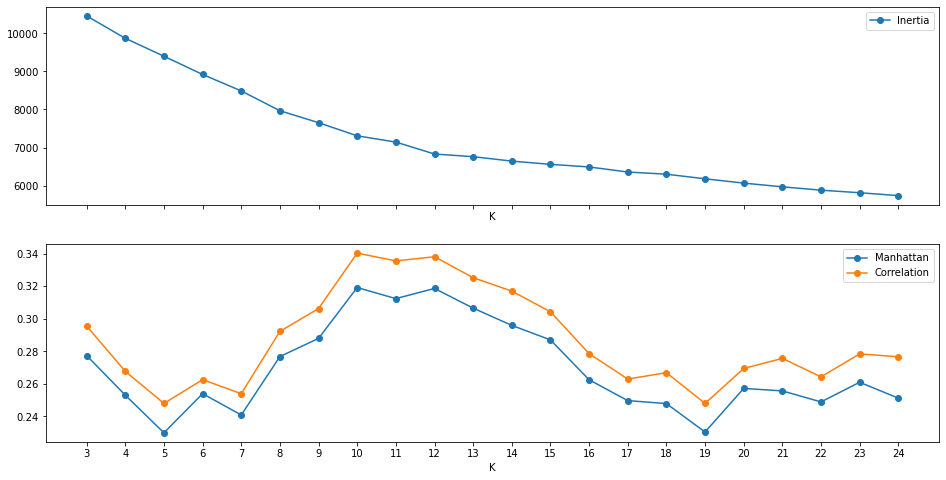

In [87]:
results = dict()
k_cand = list(np.arange(3,25,1))

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(final_df)
    score0 = kmeans.inertia_
    score1 = silhouette_score(final_df,kmeans.labels_,metric='manhattan')
    score2 = silhouette_score(final_df,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Manhattan')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4224 samples in 0.000s...
[t-SNE] Computed neighbors for 4224 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4224
[t-SNE] Computed conditional probabilities for sample 2000 / 4224
[t-SNE] Computed conditional probabilities for sample 3000 / 4224
[t-SNE] Computed conditional probabilities for sample 4000 / 4224
[t-SNE] Computed conditional probabilities for sample 4224 / 4224
[t-SNE] Mean sigma: 0.632246
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.555679
[t-SNE] KL divergence after 500 iterations: 0.508362


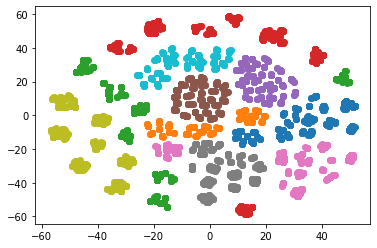

In [88]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(final_df)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[10]['k'].labels_
#pass to plotly plot to map categorical varibles
for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1]
               )


In [98]:
num_clusters = 10
neighbors = 150
distance = 0.99
random_state = 0

umap_embedding = (umap
                  .UMAP(metric='dice', n_neighbors=neighbors, min_dist=distance, n_components=2)
                  .fit_transform(final_df))
                  
                  
clusters = (KMeans(n_clusters=num_clusters, init='k-means++',
                  verbose=0, random_state=random_state,
                  algorithm='lloyd')
            .fit(umap_embedding)
            .labels_)


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable



In [99]:
plot_data = {'UMAP_1' : umap_embedding[:, 0],
             'UMAP_2' : umap_embedding[:, 1],
             'Cluster' : clusters,
             'Reaction_Set' : merged_df['Reaction_Set'].tolist(),
             'Subsystem' : merged_df['Subsystem'].tolist(),
             'Condition' : condition_column,
             'Study' : merged_df['Study'].tolist()}

umap_df = pd.DataFrame.from_dict(plot_data)
display(umap_df)

,UMAP_1,UMAP_2,Cluster,Reaction_Set,Subsystem,Condition,Study
0,13.887159,22.333239,7,ATP,S_Starch_and_Sucrose_Metabolism,m9-EX_glc_e7.44,Muconate_Study
1,-0.377285,36.273010,3,ATP,S_Fatty_Acid__Biosynthesis,m9-EX_glc_e7.44,Muconate_Study
2,-0.229290,26.481493,5,ATP,S_Glutamate_Metabolism,m9-EX_glc_e7.44,Muconate_Study
3,14.120558,22.193054,7,ATP,S_PHAs_Metabolism,m9-EX_glc_e7.44,Muconate_Study
4,-9.614811,15.555872,5,ATP,S_TCA_Cycle,m9-EX_glc_e7.44,Muconate_Study
...,...,...,...,...,...,...,...
4219,23.103640,0.075593,0,NBR,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,m9-EX_glc_e7.44,Aromatics_Study
4220,22.571417,0.398665,0,NBR,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,m9-EX_glc_e7.44,Aromatics_Study
4221,21.870914,0.634007,0,NBR,S_Glutamate_Metabolism,m9-EX_glc_e7.44,Aromatics_Study
4222,22.978718,0.115308,0,NBR,S_Cell_Envelope_Biosynthesis__Biosynthesis_of_...,m9-EX_glc_e7.44,Aromatics_Study


In [100]:
umap_df["Cluster"] = umap_df["Cluster"].astype(str)

fig = px.scatter(umap_df,
                 x="UMAP_1", y="UMAP_2",
                 color='Cluster',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition'],
                 color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()